#Assignment Part 2 '**Detective Vision**'

Detective Vision—the security firm that safeguards some of the city's most important buildings. Recently, one of our high-profile clients reported a series of suspicious activities around their building and parking lot. The client is particularly concerned about certain vehicles that have been seen entering the premises at odd hours.

Your mission is to develop a **Streamlit** application that can quickly identify any car by its **license plate number**.

A user can input any car license number into the Streamlit window, and the output should be the actual car image with the timestamp image indicating when that car enters the building (which is the timestamp of data entry in the database).

Your application could be the key to solving this mystery and ensuring the safety of the building's occupants.

In [25]:
# from google.colab import drive
# drive.mount('/content/drive')

pip install opencv-python tesseract pandas numpy


In [26]:
# Environment Setup
# Load libraries
import cv2
import pytesseract
import numpy as np
import pandas as pd
import re
import os
import csv

from ultralytics import YOLO
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import statistics as st

#  License Plate Detection: 10 Marks
Now, it's time to dive deeper into the heart of the operation. Your task is to detect and isolate the license plates from the images provided, ensuring that only the most relevant information is extracted for further analysis.

### Plate Detection:

Identify and isolate potential license plate regions from the images.

Implement method for detecting license plates, exploring detection techniques such as Yolo.

In [27]:
# Helper function
def show_image(image):
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()


0: 576x640 1 license_plate, 49.9ms
Speed: 4.0ms preprocess, 49.9ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 640)


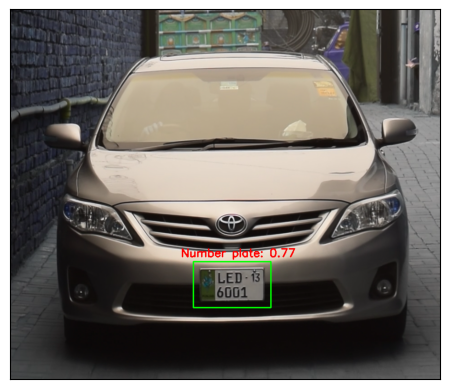

In [28]:
def detect_Np(image_path):
  # Read the image
  image = cv2.imread(image_path)

  # Run YOLO model on the image
  results = yolo_model(image)
  
  # Process YOLO results
  for result in results[0].boxes.data.tolist():
    x1, y1, x2, y2 = [int(r) for r in result[:4]]
    score, class_id = result[4], int(result[5])

    if class_id == 0:
      # Draw a rectangle around the detected car
      cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

      # Optionally: Display the detected object label (e.g., 'Number plate')
      label = f"Number plate: {score:.2f}"
      cv2.putText(image, label, (x1-25, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 2)

  # Display the result
  cv2.imshow("License plate ditection", image)
  
  # Save the result to disk (optional)
  cv2.imwrite("./detected_license/sample_test_detection.jpg", image)

  # Wait for a key press to close the window
  cv2.waitKey(0)
  cv2.destroyAllWindows()

  image_info = [x1, y1, x2, y2, score, class_id]
  return image, image_info

# Load pre-trained YOLO model (fine-tune with custom dataset if needed)
yolo_model = YOLO("license_plate_detector.pt")

# Path to your image file
image_path = "./Images/2024-01-30_18-54.png"

# Test the above defind function for you input image
detected_np, detected_np_info = detect_Np(image_path=image_path)
show_image(detected_np)


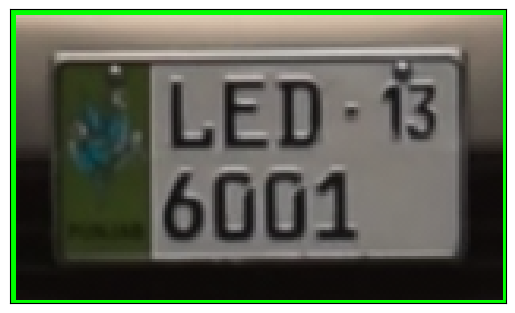

In [29]:
# crop license number plate
def crop_image(detected_np, detected_np_info):
  # code here
  x1, y1, x2, y2, score, class_id = detected_np_info
  detected_np = detected_np[y1:y2, x1:x2]

  return detected_np

cropped_lp = crop_image(detected_np, detected_np_info)
show_image(cropped_lp)

# Character Recognition: 15 Marks

With the license plates now isolated, you’re entering the critical phase of the operation. Your mission is to extract the characters from these plates and convert them into readable text. This will require precision and adaptability, as the plates may vary in font and size.

### Character Segmentation:

Break down the detected license plates into individual characters.

**Tasks:**
Segment the detected license plate regions into distinct characters, ensuring that each letter and number is isolated.
Handle variations in fonts and sizes by implementing adaptive thresholding techniques to achieve consistent segmentation results, regardless of plate design.

**Optical Character Recognition (OCR):**

Convert segmented characters into text using a trained convolutional neural network.

**Tasks:**
Utilize the CNN classifier model of **Part 1** to classifiy character of number plate.
Implement error correction mechanisms to address potential misrecognitions.


In [30]:
# helper function for countors identification
def find_contours(dimensions, img):
    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or 15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    img_res = []
    widths = []
    heights = []
    contours = []  # Store contour coordinates here

    # Calculate the middle line of the license plate
    middle_line = img.shape[0] // 2

    # Sort contours based on x-coordinate and then on y-coordinate
    sorted_cntrs = sorted(cntrs, key=lambda c: (c[0][0][0], c[0][0][1]))

    # Separate contours above and below the middle line
    above_middle = []
    below_middle = []
    for cntr in sorted_cntrs:
        x, y, w, h = cv2.boundingRect(cntr)

        if y < middle_line:
            above_middle.append((x, y, w, h, cntr))
        else:
            below_middle.append((x, y, w, h, cntr))

    # Sort contours from left to right
    above_middle = sorted(above_middle, key=lambda c: c[0])
    below_middle = sorted(below_middle, key=lambda c: c[0])

    # Process contours above the middle line
    for x, y, w, h, cntr in above_middle:
        if w > lower_width and w < upper_width and h > lower_height and h < upper_height:
            char = img[y:y+h, x:x+w]
            white_pixels = np.sum(char == 255)
            total_pixels = char.size
            white_percentage = (white_pixels / total_pixels) * 100

            if white_percentage >= 25:
                x_cntr_list.append((x, y))  # stores the (x, y) coordinates of the character's contour
                widths.append(w)
                heights.append(h)
                contours.append((x, y, x+w, y+h))  # Append contour coordinates

                char_copy = np.zeros((44, 24))
                # Extracting each character using the enclosing rectangle's coordinates.
                char = cv2.resize(char, (20, 40))

                cv2.rectangle(ii, (x, y), (x+w, y+h), (50, 21, 200), 2)
                plt.imshow(ii, cmap='gray')

                # Make result formatted for classification: invert colors
                char = cv2.subtract(255, char)

                # Resize the image to 24x44 with a black border
                char_copy[2:42, 2:22] = char
                char_copy[0:2, :] = 0
                char_copy[:, 0:2] = 0
                char_copy[42:44, :] = 0
                char_copy[:, 22:24] = 0

                img_res.append(char_copy)  # List that stores the character's binary image (unsorted)

    # Process contours below the middle line
    for x, y, w, h, cntr in below_middle:
        if w > lower_width and w < upper_width and h > lower_height and h < upper_height:
            char = img[y:y+h, x:x+w]
            white_pixels = np.sum(char == 255)
            total_pixels = char.size
            white_percentage = (white_pixels / total_pixels) * 100

            if white_percentage >= 25:
                x_cntr_list.append((x, y))  # stores the (x, y) coordinates of the character's contour
                widths.append(w)
                heights.append(h)
                contours.append((x, y, x+w, y+h))  # Append contour coordinates

                char_copy = np.zeros((44, 24))
                # Extracting each character using the enclosing rectangle's coordinates.
                char = cv2.resize(char, (20, 40))

                cv2.rectangle(ii, (x, y), (x+w, y+h), (50, 21, 200), 2)
                plt.imshow(ii, cmap='gray')

                # Make result formatted for classification: invert colors
                char = cv2.subtract(255, char)

                # Resize the image to 24x44 with a black border
                char_copy[2:42, 2:22] = char
                char_copy[0:2, :] = 0
                char_copy[:, 0:2] = 0
                char_copy[42:44, :] = 0
                char_copy[:, 22:24] = 0

                img_res.append(char_copy)  # List that stores the character's binary image (unsorted)

    # Calculate median width and height
    median_width = st.median(widths)
    median_height = st.median(heights)

    # Filter characters based on width and height deviation from the median
    filtered_img_res = []
    filtered_contours = []
    for char, contour in zip(img_res, contours):
        x1, y1, x2, y2 = contour
        if ((x2 - x1) >= 0.70 * median_width) and ((x2 - x1) <= 1.3 * median_width) and ((y2 - y1) >= 0.70 * median_height) and ((y2 - y1) <= 1.3 * median_height):
            filtered_img_res.append(char)
            filtered_contours.append(contour)

    # Remove contours with a distance of more than 15 pixels between them
    remaining_contours = []
    remaining_filtered_img_res = []
    if len(filtered_contours) > 1:
        center_x = img.shape[1] / 3
        distance = 0
        count = 1
        for i in range(1, len(filtered_contours)):
            if count >= len(filtered_contours):
                break
            x1_prev, _, x2_prev, _ = filtered_contours[count - 1]
            x1_curr, _, x2_curr, _ = filtered_contours[count]
            distance = x1_curr - x2_prev
            # print (f"Distance between contours {count} and {count+1}: {distance}")
            if distance <= -175:
                count += 1
                continue
            elif distance <= 15:
                # print("if (distance <= 15):")
                remaining_contours.append(filtered_contours[count - 1])
                remaining_filtered_img_res.append(filtered_img_res[count - 1])
                count += 1
            elif x1_curr < center_x:
                # print("elif x1_curr < center_x:")
                remaining_contours.append(filtered_contours[count])
                remaining_filtered_img_res.append(filtered_img_res[count])
                count +=2
            elif x1_curr >= (center_x * 2):
                # print("elif x1_curr >= center_x:")
                remaining_contours.append(filtered_contours[count - 1])
                remaining_filtered_img_res.append(filtered_img_res[count - 1])
                count +=2
            else:
                # print("else:")
                remaining_contours.append(filtered_contours[count - 1])
                remaining_filtered_img_res.append(filtered_img_res[count - 1])
                count += 1

        # print("Last contour")
        remaining_contours.append(filtered_contours[-1])
        remaining_filtered_img_res.append(filtered_img_res[-1])

    plt.show()

    return np.array(remaining_filtered_img_res)


In [31]:
# Find characters in the resulting images
def segment_characters(image) :
    # Preprocess cropped license plate image    
    # resize image
    resized_image = cv2.resize(image, (333, 100))

    # grey scale conversion
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    gray_image = gray_image * 255

    # apply a threshold to binarize the grey scale image
    threshold_value = 190
    ret, thresh_image = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # apply some morphological operators
    kernel_3x3 = np.ones((3, 3), np.uint8)
    kernel_4x4 = np.ones((4, 4), np.uint8)

    dilated_image = cv2.dilate(thresh_image, kernel_3x3, iterations=1)
    eroded_image = cv2.erode(dilated_image, kernel_4x4, iterations=1)
    dilated_image = cv2.dilate(eroded_image, kernel_4x4, iterations=1)
    eroded_image = cv2.erode(dilated_image, kernel_3x3, iterations=1)
    image = eroded_image

    # Make borders white
    border_thickness = 5
    border = border_thickness * 2
    LP_WIDTH, LP_HEIGHT = image.shape[:2]
    
    image[0:border, :] = 255
    image[:, 0:border] = 255
    image[LP_WIDTH-border:, :] = 255
    image[:, LP_HEIGHT-border:] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/10,
                  2*LP_WIDTH/2.5,
                  LP_HEIGHT/20,
                  2*LP_HEIGHT/2.5]
    img_binary_lp = image
    cv2.imwrite('contour.jpg', img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

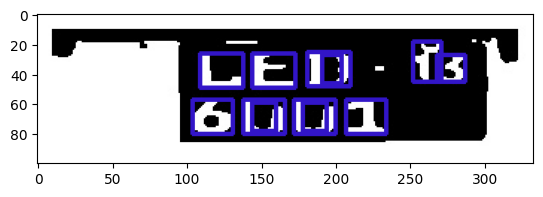

In [32]:
# Test the function
# Reading cropped license plate image
char = segment_characters(cropped_lp)

In [33]:
# Set the device (use GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define the convolutional neural network model
class CNNNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNNNet, self).__init__()

        # Convolutional layers
        self.conv_l1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3)

        self.conv_l2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

        self.conv_l3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)

        # Pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc_1 = nn.Linear(in_features=(30976), out_features=num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply convolutional layers with ReLU activation and pooling
        x = self.conv_l1(x)
        x = self.relu(x)

        x = self.conv_l2(x)
        x = self.relu(x)

        x = self.conv_l3(x)
        x = self.relu(x)

        # Dynamically flatten the output from the conv layers
        x = x.view(x.size(0), -1)

        # Fully connected layers with ReLU activation
        x = self.fc_1(x)

        # Output layer (log_softmax for classification)
        output_layer = nn.LogSoftmax(dim=1)(x)

        return output_layer

# Initialize the model, loss function, and optimizer
in_channels = 1
num_classes = 36
cnn_net_model = CNNNet(in_channels=in_channels, num_classes=num_classes).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_net_model.parameters(), lr=1e-3)

In [34]:
# Initialize the model
# Ensure to define your model class again
in_channels = 1
num_classes = 36
cnn_net_model = CNNNet(in_channels=in_channels, num_classes=num_classes).to(device)

# Load the model's state dictionary
path = './cnn_net.pt'
cnn_net_model.load_state_dict(torch.load(path))

# Set the model to evaluation mode (if you're going to evaluate it)
cnn_net_model.eval()

CNNNet(
  (conv_l1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_l2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_l3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=30976, out_features=36, bias=True)
  (relu): ReLU()
)

In [35]:
# Preprocess input image for character prediction
def fix_dimension(img):
    # Ensure the image is in the correct format (28, 28, 1) for grayscale
    img = cv2.resize(img, (28, 28))

    if len(img.shape) == 2:
        img = np.expand_dims(img, axis=2)
    
    return img

def show_results(characters, char):
    dic = {i: c for i, c in enumerate(characters)}

    output = []
    for i, ch in enumerate(char):  # Iterating over the characters
        # resize image
        # Preparing image for the model (N, C, H, W)
        # Convert to PyTorch tensor and normalize
        # Normalize to [0, 1]
        image = fix_dimension(ch)
        image = T.ToTensor()(image) / 255
        image = T.functional.invert(image)
        
        # Single image  processing
        if len(image.shape) == 3:
            image = image.expand(1, -1, -1, -1)

        # Make prediction
        # No gradient tracking for inference
        # Forward pass
        # Get predicted class
        
        with torch.no_grad():
            outputs = cnn_net_model(image.float().to(device)).detach().cpu()
        
        output_idx = int(np.argmax(outputs, axis=1))
        output.append(dic[output_idx])

    # Storing the result in a list
    plate_number = ''.join(output)
    return plate_number

# Example characters to predict
characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
# Assume `char` is a list of character images (each image is a numpy array)
lp_number = show_results(characters, char)
print(lp_number)


LED6001


# Logging: 10 Marks

With the license plates successfully recognized, it’s time to finalize the operation by logging the critical information.

**Tasks:**

### Extract Timestamps:
**Objective:**
Identify and log the specific time and image label.

**Tasks:**
Develop a method to extract the image label and the timestamp corresponding to each detected license plate (time when entry was created in the database).
Ensure this information is accurately logged and associated with the correct license plate number for easy retrieval and reporting.




0: 608x640 1 license_plate, 36.6ms
Speed: 4.5ms preprocess, 36.6ms inference, 6.6ms postprocess per image at shape (1, 3, 608, 640)


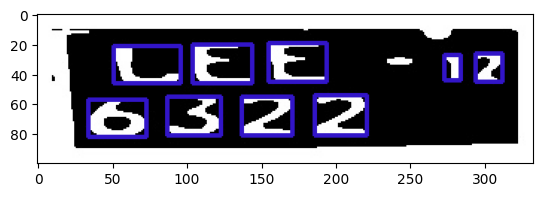

Detected License Plate: LEE6322

0: 608x640 1 license_plate, 12.3ms
Speed: 3.0ms preprocess, 12.3ms inference, 2.5ms postprocess per image at shape (1, 3, 608, 640)


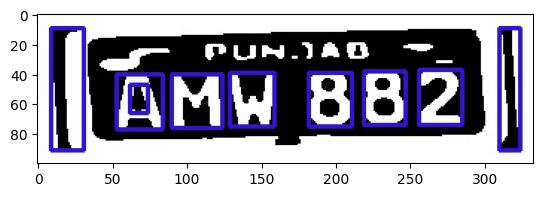

Detected License Plate: AMW882

0: 576x640 1 license_plate, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 640)


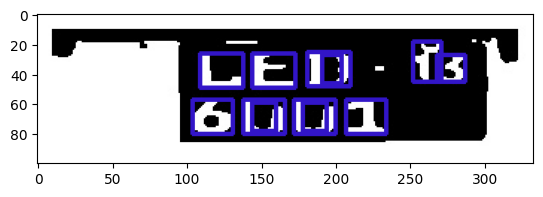

Detected License Plate: LED6001

0: 640x288 1 license_plate, 20.2ms
Speed: 2.0ms preprocess, 20.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 288)


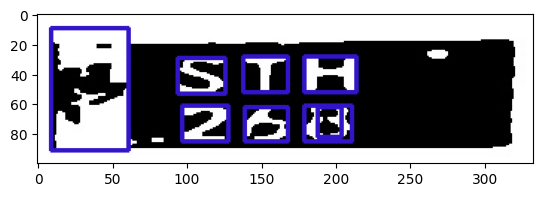

Detected License Plate: STH268

0: 640x384 1 license_plate, 18.7ms
Speed: 2.0ms preprocess, 18.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


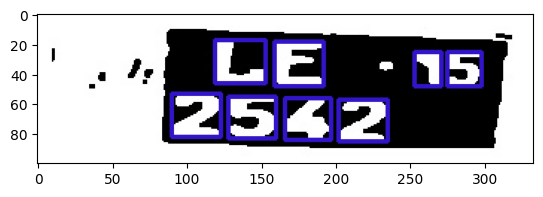

Detected License Plate: LE2542

0: 480x640 1 license_plate, 27.6ms
Speed: 4.0ms preprocess, 27.6ms inference, 8.0ms postprocess per image at shape (1, 3, 480, 640)


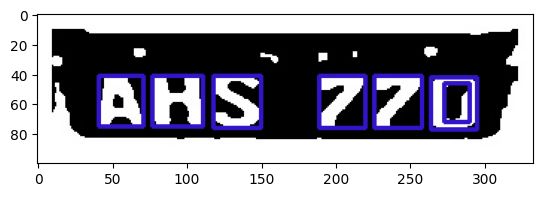

Detected License Plate: AHS770

0: 608x640 1 license_plate, 32.6ms
Speed: 5.6ms preprocess, 32.6ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)


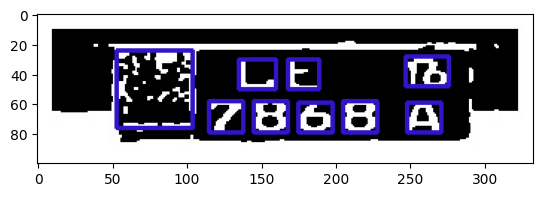

Detected License Plate: LE7868A

0: 288x640 1 license_plate, 14.7ms
Speed: 2.0ms preprocess, 14.7ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)


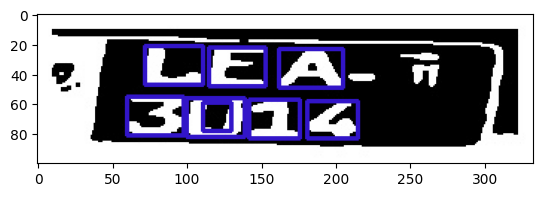

Detected License Plate: LEA3014

0: 288x640 1 license_plate, 17.8ms
Speed: 3.0ms preprocess, 17.8ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


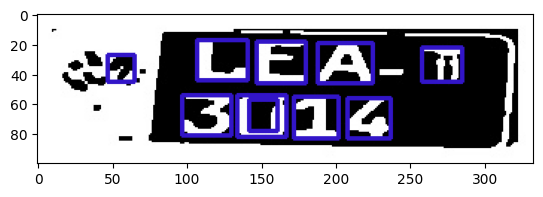

Detected License Plate: LEA3014


In [36]:
yyyy_mm_dd= r"(\d{4})-(\d{2})-(\d{2})"
hh_mm = r"_(\d{2})-(\d{2})"
yyyy = r"(\d{4})"
folder = "./Images"
characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
csv_file = "car_logs.csv"

if not os.path.isfile(csv_file):
    with open(csv_file, "w", newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=["Number Plate", "Image Label", "Timestamp"])
        writer.writeheader()

# read images from directory
for file_name in os.listdir(folder):
    file_path = os.path.join(folder, file_name)

    # recognize the car license number
    # Number plate detection
    detected_np, detected_np_info = detect_Np(file_path)
    cropped_np = crop_image(detected_np, detected_np_info)
    char = segment_characters(cropped_np)
    lp_number = show_results(characters, char)
    print(f"Detected License Plate: {lp_number}")

    # Generate a database entry (inn a CSV file) containing the car license number, image label (e.g., img1.png or img2.jpg), and
    # the timestamp of when the entry is created.
    match_time_stamp_1 = re.search(yyyy_mm_dd, file_path)
    if match_time_stamp_1:
        time_stamp_1 = match_time_stamp_1.group(0)

        time_stamp_2 = ""
        match_time_stamp_2 = re.search(hh_mm, file_path)
        if match_time_stamp_2:
            time_stamp_2 = match_time_stamp_2.group(0)
            time_stamp_2 = time_stamp_2.replace("_", " ")
            time_stamp_2 = time_stamp_2.replace("-", ":") + ":00"

        time_stamp = time_stamp_1 + time_stamp_2
    else:
        match_time_stamp_3 = re.search(yyyy, file_path)
        if match_time_stamp_3:
            time_stamp = match_time_stamp_3.group(0)

    with open(csv_file, "a", newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=["Number Plate", "Image Label", "Timestamp"])
        data = [{"Number Plate":lp_number, "Image Label":file_path, "Timestamp":time_stamp}]
        writer.writerows(data)

# Streamlit Integration and Safe City Deployment: 15 Marks

Agent, your final task is to integrate all your hard work into a user-friendly application that can be deployed in the real world. With Safe City cameras employed everywhere, your Streamlit application will play a crucial role in maintaining security across the city. This mission will require you to develop a streamlined web application that automatically recognizes license plates from uploaded images and logs the data for easy access and analysis.

**Tasks:**

### Streamlit Web Application Development:

Create a simple, yet effective, web application using Streamlit that integrates your previous work into a cohesive system.

Develop a Streamlit application allowing users to enter car license numbers and generate car images with corresponding timestamps.



# Assessment Criteria: Operation Detective Vision

As you complete the mission, your work will be assessed based on the following key criteria:

## Technical Competence:

**Effectiveness:** How well does your system perform in terms of recognizing and logging license plates? Are the results accurate and reliable?

**Integration:** How seamlessly have you integrated all components of the project into the final Streamlit application? Is the user interface intuitive and user-friendly?
